---

<center><h1> COM 405 Fall 2025: Mobile networks </h1></center>

<center><h2> Lab Assignment 2 </h2></center>

<center><h2> MIMO </h2></center>

---

In this lab, you will learn how to decode MIMO signals. The code for this lab will be written in Python. All the codes will be written in this file. We will instruct you which cells and in which parts of the cell you should write your code. The places that need to be filled out by you are marked by **# Your Code Starts Here #** and **# Your Code Ends Here #**.

We will provide you with wireless signals on which you can test your code. The lab will be divided into several tasks. Each task will require you to run some test script which will output a file or plot a figure. These results are needed for our evaluation. You will have to keep the figures and the output files and submit them along with this completed file.

---


# 1. Introduction
The main directory consists of this file, ``MIMO_Lab.ipynb``, and three subfolders. 
All the code that you have to write and execute will be written in this file.
Some cells of this file are the test scripts that will run your code on the test files and save the result for our evaluation.
Consequently, you do not need to modify those cells. 
You just have to run them to save the results.
Moreover, the test cells use some test data located at ``Mat_Test`` directory.
<span style="color:red">
As a result, do not change the directories' name and location, otherwise the test scripts will not work, and you will lose the points.
The same applies for the location of this file, ``MIMO_Lab.ipynb``.
</span>

<span style="color:red">

**Very Important Note:** The inputs and outputs of each function that you will write is specified on top of the function. 
It is very important to comply with the type, shape, and the order of outputs specified for each function. 
If you do not comply with them, the test scripts will not work or, even worth, it will work and output the wrong results.
In this case you will lose the points for that function and consecutive dependent tests.
Moreover, please pay attention to the order of the outputs if the function has more than one.

For the type of variables, for example if it is written ``numpy.ndarray: complex128``, it means that the variable should be a NumPy array of complex128 variables. 

</span>

The main directory has three subfolders:
* **Mat_Files:** Signals and parameters that will help you complete the functions. You can verify the correctness of your code with the given data.
* **Mat_Test:** Your code will be tested on the data in this folder. The results are meant for us to evaluate the correctness of your implementation.
* **Results:** This folder is initially empty. When you run certain cells in this file, some result will be saved in the folder. Make sure that when you run those cells, the result appears in the folder, otherwise you lose the points for those results. 

In this lab:
* We will assume all channels are narrowband and hence the channel is flat and can be represented by a single number. Note that this is not very realistic for 20MHz channels, but we did it to simplify the lab. In practice for 20MHz, we do the channel estimation effectively for each subcarrier. 
* We will not need packet detection. 
The signals you are given already went through packet detection, and you can assume that the first sample in the received signal is the first sample of the packet.
* We do not need to worry about synchronization i.e. CFO and SFO are zero so CFO estimation and correction and phase tracking are not needed for this lab.
* In the signals we give you, we dropped the preamble part corresponding to packet detection and CFO estimation. 
The data symbols however do contain pilots which we will ignore.
* For this lab, we will only use BPSK modulation.
* We have supplied you with the functions ``tx_ofdm_chain`` and ``rx_ofdm_chain_synced`` from Lab 1. 
They have been slightly modified since we do not need packet detection or CFO estimation. 
The script already calls these function where they are needed.
* Some tests will calculate the BER. 
To verify whether the BER makes sense you need to check your estimates of the channel. 
You can use the built-in NumPy function ``numpy.linalg.cond(A)`` to calculate the condition number of the channel matrix.
* The OFDM parameters of this lab are different from those for Lab 1. 
For this lab, you will use the OFDM parameters shown in the Table. 1. The variables are stored in the file ``Parameters.mat``. 
At the beginning of each cell that you should fill, we already loaded the required parameters.
Load more if you need more. 
* For some functions that you should implement, some of the code that you should write is already given by us as help.
It would be very helpful to try and use them.
But, of course, if you prefer to write the whole code yourself, you can easily remove our code and write the whole code yourself.
Nevertheless, you should always comply with the outputs' order and format (type and shape).  

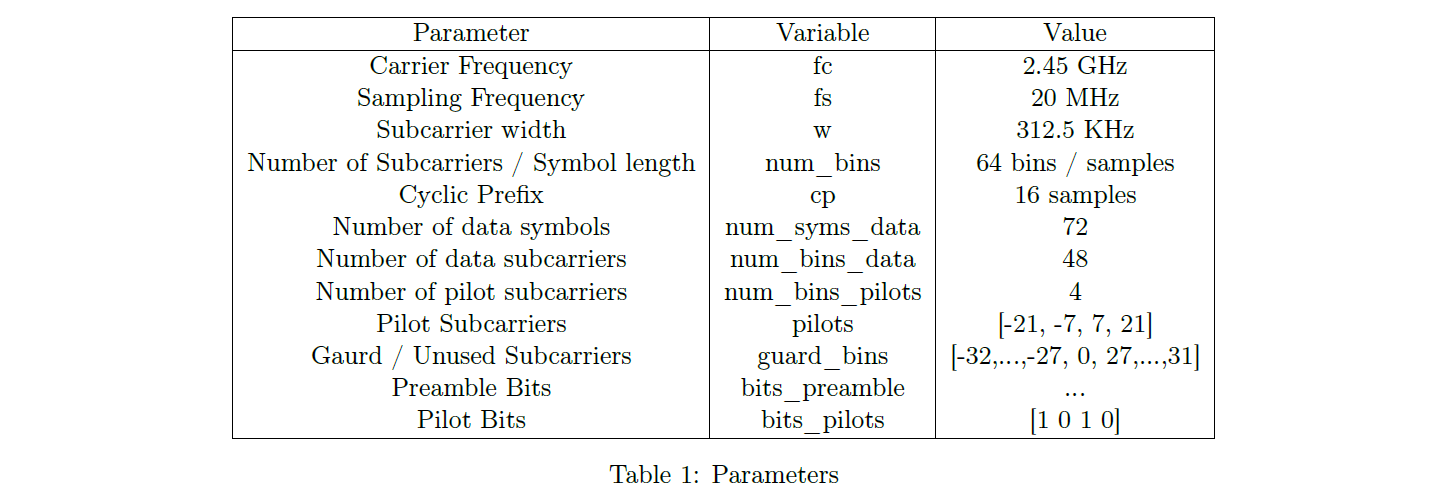

## Helper Functions
All the helper functions that you can use in your code is provided in the following python cell.
Please do not forget to run the following cell, so that the later cells can find these helper functions. 

<span style="color:red">

It is very important to pay attention to the format of the inputs and outputs of these helper functions in order to use them. 
As a result, please read the inputs and outputs format in the following cell before using the helper functions. 

</span>

In [1]:
"""
    @param normal_bin_index: The normal bin indices. 
    For example you can input the "guard_bins" which is in the "parameters.mat" file to this function. 
    @type  normal_bin_index: int16
    @shape normal_bin_index: (N,)
    
    @param num_bins: The number of bins. 
    You can give the "num_bins" in the "parameters.mat" file to this function. 
    @type num_bins: int
    
    @return fft_bin_index: The converted bin indices.
    @type fft_bin_index: int64
    @shape fft_bin_index: (N,)
"""
def convert_bin_index_normal_to_fft(normal_bin_index, num_bins):
    if num_bins % 2 == 0:
        normal_to_fft = np.concatenate((np.arange(num_bins//2, num_bins), np.arange(num_bins//2)))
        fft_bin_index = normal_to_fft[num_bins//2 + normal_bin_index]
    else:
        normal_to_fft = np.concatenate((np.arange((num_bins-1)//2, num_bins), np.arange((num_bins-1)//2)))
        fft_bin_index = normal_to_fft[(num_bins-1)//2 + normal_bin_index]
    
    return fft_bin_index


"""
    @param rx_signal: The signal.
    @type  rx_signal: numpy.ndarray: complex128
    @shape rx_signal: (N,)
    
    @return bits_data: The decoded bits.
    @type bits_data: numpy.ndarray: bool
    @shape bits_data: (M,)
"""
def rx_ofdm_chain_synced(rx_signal):
    # Load Parameters.mat
    params = sio.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    num_syms_data = params['num_syms_data'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)

    bits_data = np.array([], dtype=bool)

    # Subcarrier configuration
    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3

    current_index = 0

    # CHANNEL ESTIMATION
    h = estimate_channel(rx_signal[current_index:current_index + num_bins],
                         rx_signal[current_index + num_bins:current_index + 2 * num_bins])
    current_index += 2 * num_bins + cp
    # DECODING
    for i in range(num_syms_data):
        symt = rx_signal[current_index:current_index + num_bins]
        symf = (1 / np.sqrt(num_bins)) * np.fft.fft(symt)
        symf = correct_channel(symf, h)
        bits = symf[subcarrier_config == 1] < 0
        bits_data = np.concatenate((bits_data, bits))
        current_index += num_bins + cp

    return bits_data


"""
    @param rx_sym1: The symbol 1.
    @type  rx_sym1: numpy.ndarray: complex128
    @shape rx_sym1: (N,)

    @param rx_sym2: The symbol 2.
    @type  rx_sym2: numpy.ndarray: complex128
    @shape rx_sym2: (N,)
    
    @return H: The estimated channel.
    @type H: numpy.ndarray: complex128
    @shape H: (N,)
"""
def estimate_channel(rx_sym1, rx_sym2):
    # Load Parameters.mat
    params = sio.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)

    # Create tx_sym and subcarrier_config
    tx_sym = np.zeros(num_bins)
    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3
    tx_sym[subcarrier_config != 0] = 1 - 2 * bits_preamble

    # Compute the received symbol (rx_sym)
    rx_sym = (1 / np.sqrt(num_bins)) * np.fft.fft((rx_sym1 + rx_sym2) / 2)

    # Estimate the channel H
    H = np.zeros(tx_sym.shape, dtype=np.complex128)
    H[np.nonzero(tx_sym)] = rx_sym[np.nonzero(tx_sym)] / tx_sym[np.nonzero(tx_sym)]

    # Set the channel response at the guard bins to zero
    H[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0

    return H


"""
    @param rx_sym: The symbol.
    @type  rx_sym: numpy.ndarray: complex128
    @shape rx_sym: (N,)

    @param H: The channel estimate.
    @type  H: numpy.ndarray: complex128
    @shape H: (N,)
    
    @return rx_sym_no_channel: The channel compensated symbol.
    @type rx_sym_no_channel: numpy.ndarray: complex128
    @shape rx_sym_no_channel: (N,)
"""
def correct_channel(rx_sym, H):
    # Load Parameters.mat
    params = sio.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)

    # Correct the received symbol by dividing by the channel estimate
    rx_sym_no_channel = np.zeros(rx_sym.shape, dtype=np.complex128)
    rx_sym_no_channel[np.nonzero(H)] = rx_sym[np.nonzero(H)] / H[np.nonzero(H)]

    # Set the values in the guard bins to zero
    rx_sym_no_channel[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0

    return rx_sym_no_channel


"""
    @param bits_data: The bit stram.
    @type  bits_data: numpy.ndarray: bool
    @shape bits_data: (N,)
    
    @return signal: The resulting signal.
    @type signal: numpy.ndarray: complex128
    @shape signal: (M,)
"""
def tx_ofdm_chain(bits_data):
    # Load parameters from the .mat file
    params = loadmat('Mat_Files/Parameters.mat')
    
    num_syms_data = params['num_syms_data'].item()
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)

    # Initialize the output signal
    signal = np.zeros(num_syms_data * (num_bins + cp) + 2 * num_bins + cp, dtype=complex)

    # Initialize symbol frequency domain
    symbol_freq = np.zeros(num_bins, dtype=complex)

    # Configure subcarriers
    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3

    # ADD PREAMBLE SYMBOLS
    for m in range(2):
        symbol_freq[subcarrier_config != 0] = 1 - 2 * bits_preamble
        symbol_time = np.sqrt(num_bins) * np.fft.ifft(symbol_freq)
        signal[m * num_bins:(m + 1) * num_bins] = symbol_time

    signal[2 * num_bins:2 * num_bins + cp] = symbol_time[:cp]

    # ADD DATA SYMBOLS
    for m in range(num_syms_data):
        symbol_freq[subcarrier_config == 1] = 1 - 2 * bits_data[m * len(symbol_freq[subcarrier_config == 1]):(m + 1) * len(symbol_freq[subcarrier_config == 1])]
        symbol_freq[subcarrier_config == 3] = 1 - 2 * np.fft.fftshift(bits_pilots)
        symbol_time = np.sqrt(num_bins) * np.fft.ifft(symbol_freq)
        start_idx = 2 * num_bins + cp + m * (num_bins + cp)
        end_idx = start_idx + num_bins + cp
        signal[start_idx:end_idx] = np.concatenate((symbol_time, symbol_time[:cp]))

    return signal


# 2. Task 1: Multiplexing Gain 2x2 MIMO

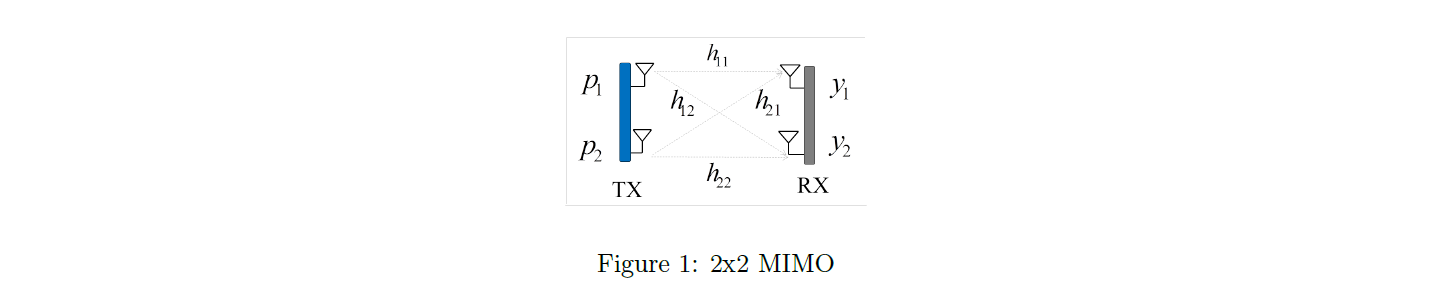


In this task, you will implement the RX chain of 2x2 MIMO receiver (Figure. 1). 
The 2x2 MIMO transmitter transmits two packets $p_1$ and $p_2$ on his two antennas. 
The packets use OFDM and their format is shown in Figure. 2. 
Pay attention to this format, because you need it later to be able to decode the two packets separately. 

Ideally, we would not transmit the channel estimation symbols except once. 
However, in this lab we want to decouple the OFDM RX chain decoding from the MIMO decoding so that you can separate the two packets $p_1$ and $p_2$ from the two received symbols $y_1$ and $y_2$ and then just feed them into a standard OFDM decoder from Lab 1.

Start by implementing the function ``estimate_narrowband_channel`` in the following cell. 
This function should take as input two OFDM symbols in the time domain (two for averaging) and should output a single complex scalar corresponding to the channel value.

**Hints:**

* You have to work with the ``bits_preamble`` to estimate the channel. 

* Do not forget the conversion of normal indices to the FFT indices which is used by NumPy. 
We already gave the function that does so in the Helper Functions section. 

* For the narrowband channel estimation, you essentially need to solve this equation:

$$
\text{Minimize} \ \sum (RX\_SYM - H \cdot TX_SYM)^2
$$

This is called the Least Squares (LS) Channel Estimation method.
The solution for it is quite straightforward, as follows (try to prove it by yourself)

$$
H = \frac{\mathbf{RX\_SYM} \cdot \mathbf{TX\_SYM}^T}{\mathbf{TX\_SYM} \cdot \mathbf{TX\_SYM}^T}
$$

* Side note: Note that $RX\_SYM$, $TX\_SYM$, and $H$ are in frequency domain in the mentioned equation.
But the inputs of the ``estimate_narrowband_channel`` function, namely ``rx_sym1`` and ``rx_sym2``, are in the time domain. 

* Note that $TX\_SYM$ (similar to Lab 1), is the **Modulated** Preamble Bits.

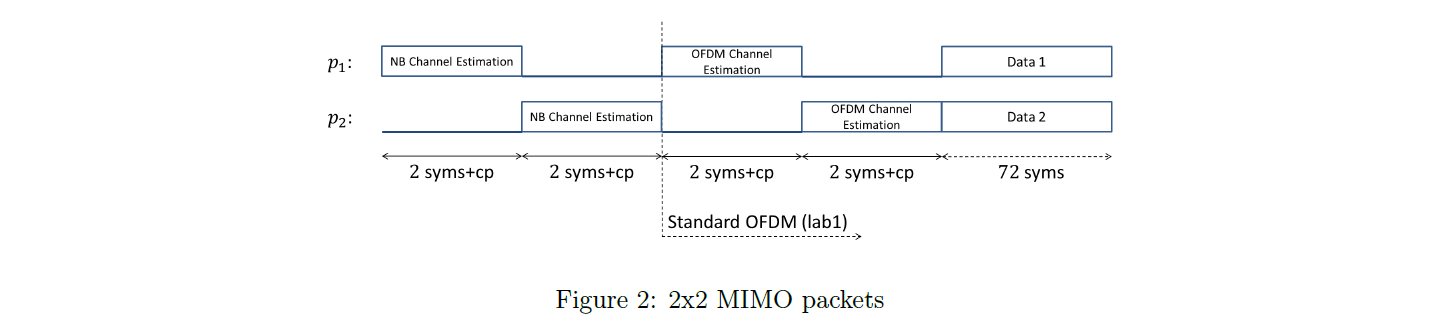

In [2]:
import numpy as np
import scipy.io as sio

"""
    @param rx_sym1: The symbol 1
    @type  rx_sym1: numpy.ndarray: complex128
    @shape rx_sym1: (N,)

    @param rx_sym2: The symbol 2
    @type  rx_sym2: numpy.ndarray: complex128
    @shape rx_sym2: (N,)
    
    @return h: Scalar narrowband channel estimate
    @type h: complex128
    @shape h: ()
"""
def estimate_narrowband_channel(rx_sym1, rx_sym2):
    # Load Parameters.mat
    params = sio.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)

    # Your Code Starts Here #

    tx_sym = np.zeros(num_bins, dtype=np.complex128)
    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3
    tx_sym[subcarrier_config != 0] = 1 - 2 * bits_preamble

    rx_sym = (1 / np.sqrt(num_bins)) * np.fft.fft((rx_sym1 + rx_sym2) / 2)

    # Least-squares scalar estimate: H = (tx^H * rx) / (tx^H * tx)
    # Note: np.vdot(a, b) computes conj(a) @ b, so use vdot(tx, rx)
    h = np.vdot(tx_sym, rx_sym) / np.vdot(tx_sym, tx_sym)

    return h

# Your Code Ends Here #

Now implement the function ``decode_2x2_mimo`` in the following cell. 
It should take two complex signals (received signals respectively at antenna 1 and 2) as inputs and should output two bit streams. 
You will need to use the provided ``rx_ofdm_chain_synced`` function (in the Helper Functions Section) to decode the two separated packets at the end of your function. 

To test your code and make sure that it works fine, you can use the file ``Eg_2x2_MIMO.mat``. 
This file contains two signals: ``rx_signal_1`` and ``rx_signal_2`` and two output bit streams: ``bits_data_1`` and ``bits_data_2``. 
Your decoded bits should match the ``bits_data_1`` and ``bits_data_2`` of the two signals.

**Hints:** 

* Do not forget to skip 1/4 of the CP.
* Estimate all the four narrowband channels using the two NB Channel Estimation in Figure 2.
Then make the H matrix using these four narrowband channels.
Then solve the linear equations.

In [3]:
import numpy as np
import scipy.io as sio

"""
    @param rx_signal_1: The signal 1
    @type  rx_signal_1: numpy.ndarray: complex128
    @shape rx_signal_1: (N,)

    @param rx_signal_2: The signal 2
    @type  rx_signal_2: numpy.ndarray: complex128
    @shape rx_signal_2: (N,)
    
    @return bits_data_1_decoded, bits_data_2_decoded: The two decoded bit streams respectively for receiver 1 and receiver 2
    @type bits_data_1_decoded, bits_data_2_decoded: numpy.ndarray: bool
    @shape bits_data_1_decoded, bits_data_2_decoded: (M,)
"""
def decode_2x2_mimo(rx_signal_1, rx_signal_2):
    # Load Parameters.mat
    params = sio.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()

    # Your Code Starts Here #

    # Initialize current index
    current_index = int(np.ceil(1 * cp / 4))
    nb_len = 2 * num_bins + cp  # Length of narrowband preamble

    # Create narrowband H matrix
    # ... add your code here ...
    nb1_rx1 = rx_signal_1[current_index:current_index + nb_len]
    nb1_rx2 = rx_signal_2[current_index:current_index + nb_len]
    nb2_rx1 = rx_signal_1[current_index + nb_len:current_index + 2 * nb_len]
    nb2_rx2 = rx_signal_2[current_index + nb_len:current_index + 2 * nb_len]

    h11 = estimate_narrowband_channel(nb1_rx1[:num_bins], nb1_rx1[num_bins:2*num_bins]) # TX1 -> RX1 on slot 1
    h21 = estimate_narrowband_channel(nb1_rx2[:num_bins], nb1_rx2[num_bins:2*num_bins]) # TX1 -> RX2 on slot 1
    h12 = estimate_narrowband_channel(nb2_rx1[:num_bins], nb2_rx1[num_bins:2*num_bins]) # TX2 -> RX1 on slot 2
    h22 = estimate_narrowband_channel(nb2_rx2[:num_bins], nb2_rx2[num_bins:2*num_bins]) # TX2 -> RX2 on slot 2
    
    H = np.array([[h11, h12],
                  [h21, h22]], dtype=np.complex128)
    current_index += 2 * nb_len

    # Separate the two streams into two packets
    # ... add your code here ...
    rx_signal_1_ofdm = rx_signal_1[current_index:]
    rx_signal_2_ofdm = rx_signal_2[current_index:]
    Y = np.vstack((rx_signal_1_ofdm, rx_signal_2_ofdm))
    packet_samples = np.linalg.solve(H, Y)
    packet_samples_1 = packet_samples[0, :]
    packet_samples_2 = packet_samples[1, :]

    # Decode the two packets separately
    packet_samples_1 = np.concatenate([packet_samples_1[:num_bins * 2 + cp], packet_samples_1[num_bins * 4 + cp * 2:]])
    packet_samples_2 = packet_samples_2[num_bins * 2 + cp:]
    bits_data_1 = rx_ofdm_chain_synced(packet_samples_1)
    bits_data_2 = rx_ofdm_chain_synced(packet_samples_2)

    return bits_data_1, bits_data_2

# Your Code Ends Here #


After implementing the functions, run the following cell (no modification is needed) to save your results in the ``Results`` folder for our evaluation. 
Make sure that your result ``Result_2x2_MIMO.mat`` is saved after running this cell.

In [4]:
import scipy.io as sio
import numpy as np

# Load necessary .mat files
test_data = sio.loadmat('Mat_Test/Test_2x2_MIMO.mat')
params = sio.loadmat('Mat_Files/Parameters.mat')

# Extract the rx_signals and initialize variables
rx_signals = test_data['rx_signals']
num_test = rx_signals.shape[1]
bits_data = [[None for _ in range(num_test)] for _ in range(2)]

# Process each pair of signals
for k in range(num_test):
    rx_signal_1 = rx_signals[0, k].flatten()
    rx_signal_2 = rx_signals[1, k].flatten()
    
    bits_data_1, bits_data_2 = decode_2x2_mimo(rx_signal_1, rx_signal_2)
    
    bits_data[0][k] = np.array(bits_data_1)
    bits_data[1][k] = np.array(bits_data_2)

# Save the results to a .mat file
sio.savemat('Results/Result_2x2_MIMO.mat', {'bits_data': bits_data})

In [5]:
# ## Code for debugging
# import scipy.io as sio
# import numpy as np

# # Load necessary .mat files
# debug_data = sio.loadmat('Mat_Files/Eg_2x2_MIMO.mat')
# params = sio.loadmat('Mat_Files/Parameters.mat')
# print(debug_data.keys())

# # Extract the rx_signals and initialize variables
# rx_signal_1 = debug_data['rx_signal_1'].flatten()
# rx_signal_2 = debug_data['rx_signal_2'].flatten()
# bits_data_1, bits_data_2 = decode_2x2_mimo(rx_signal_1, rx_signal_2)

# debug_bits_data_1 = debug_data['bits_data_1'].flatten()
# debug_bits_data_2 = debug_data['bits_data_2'].flatten()

# print(bits_data_1.shape)
# print(debug_bits_data_1.shape)

# print(f"Errors in decoding p1: {np.count_nonzero(bits_data_1 != debug_bits_data_1)} / {bits_data_1.shape[0]}")
# print(f"Errors in decoding p2: {np.count_nonzero(bits_data_2 != debug_bits_data_2)} / {bits_data_2.shape[0]}")

# print(bits_data_1 - debug_bits_data_1)
# print(bits_data_2 - debug_bits_data_2)

# 3. Task 2: Diversity Gain 1x2 MIMO

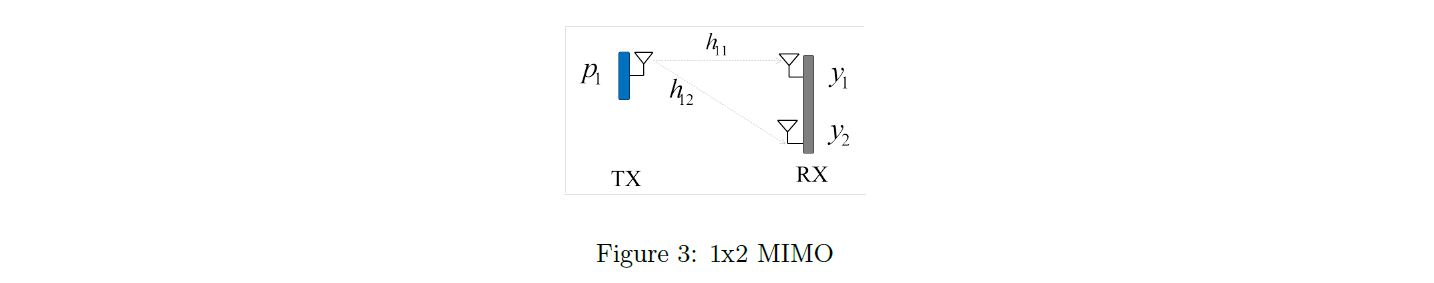

In this task, you will implement the RX chain of 1x2 MIMO receiver (Figure. 3). 
The transmitter transmits one packet $p_1$. 
The packet uses OFDM and its format is shown in Figure. 4.

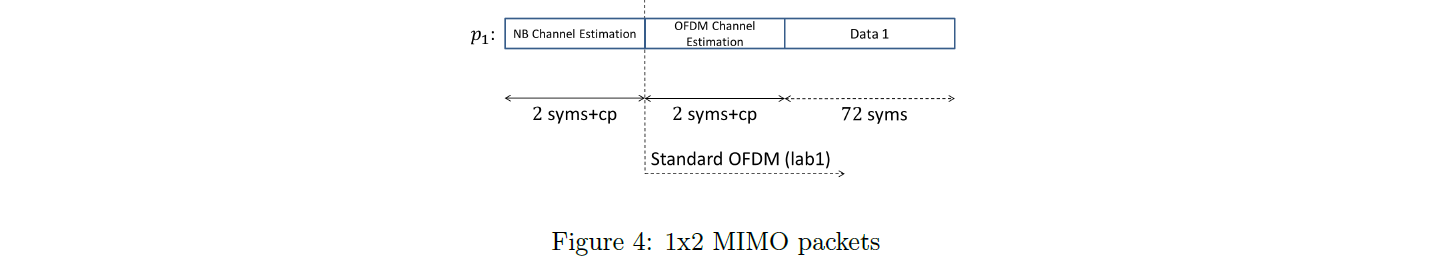

Implement the function ``decode_1x2_independent`` in the following cell. 
This function will decode the signals received on the two antennas separately, so you do not need to estimate the narrowband channel for it anymore. 
It should take two complex signals as inputs (received signals respectively at antenna 1 and 2) and should output two bit streams. 
If both channels to the receiver antennas are good, then the two bit streams should be identical.

**Hints:** 

* Do not forget to skip 1/4 of the CP.
* Again, you have to use the ``rx_ofdm_chain_synced`` function to decode the two packets separately.
The output for them should be identical.

In [6]:
"""
    @param rx_signal_1: The signal 1
    @type  rx_signal_1: numpy.ndarray: complex128
    @shape rx_signal_1: (N,)

    @param rx_signal_2: The signal 2
    @type  rx_signal_2: numpy.ndarray: complex128
    @shape rx_signal_2: (N,)
    
    @return bits_data_1, bits_data_2: The two decoded bit streams respectively for receiver 1 and receiver 2
    @type bits_data_1, bits_data_2: numpy.ndarray: bool
    @shape bits_data_1, bits_data_2: (M,)
"""
def decode_1x2_independent(rx_signal_1, rx_signal_2):
    # Load parameters from the .mat file
    params = sio.loadmat('Mat_Files/Parameters.mat')
    cp = params['cp'].item()
    num_bins = params['num_bins'].item()

    # Your Code Starts Here #

    # Use this variable to keep track at which sample you are in packet
    current_index = int(np.ceil(1 * cp / 4))

    # Skip Narrowband Channel Estimation
    current_index += 2 * num_bins + cp

    # Decode the packets separately
    # ... add your code here ...
    bits_data_1 = rx_ofdm_chain_synced(rx_signal_1[current_index:])
    bits_data_2 = rx_ofdm_chain_synced(rx_signal_2[current_index:])

    return bits_data_1, bits_data_2

# Your Code Ends Here #

Next, implement the ``decode_1x2_joint`` function in the following cell. 
This function will decode the signals received on the two antennas jointly. 
It should take two complex signals as inputs (received signals respectively at antenna 1 and 2) and should output 1 bit stream. 
This time you will need the narrowband channel estimation. 

This implementation is actually better than the previous one. 
Think about the reason. 

To test your code and make sure that it works fine, you can use the file ``Eg_1x2_MIMO.mat``. 
This file contains two signals: ``rx_signal_1`` and ``rx_signal_2`` and two output bit stream: ``bits_data``. 
Your decoded bits should match the ``bits_data``. 

In [7]:
"""
    @param rx_signal_1: The signal 1
    @type  rx_signal_1: numpy.ndarray: complex128
    @shape rx_signal_1: (N,)

    @param rx_signal_2: The signal 2
    @type  rx_signal_2: numpy.ndarray: complex128
    @shape rx_signal_2: (N,)
    
    @return bits_data: The jointly decoded bit stream
    @type bits_data: numpy.ndarray: bool
    @shape bits_data: (M,)
"""
def decode_1x2_joint(rx_signal_1, rx_signal_2):
    # Load parameters from the .mat file
    params = sio.loadmat('Mat_Files/Parameters.mat')
    cp = params['cp'].item() 
    num_bins = params['num_bins'].item()

    # Your Code Starts Here #

    num_syms_data = params['num_syms_data'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)

    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3

    # Use this variable to keep track of which sample you are in the packet
    current_index = int(np.ceil(1 * cp / 4))

    # Estimate Narrowband Channels
    # ... add your code here ...
    current_index += 2 * num_bins + cp # Skip narrowband channel estimation

    # OFDM channel estimation
    h11 = estimate_channel(rx_signal_1[current_index : current_index + num_bins],
                           rx_signal_1[current_index + num_bins : current_index + 2 * num_bins])
    h12 = estimate_channel(rx_signal_2[current_index : current_index + num_bins],
                           rx_signal_2[current_index + num_bins : current_index + 2 * num_bins])

    current_index += 2 * num_bins + cp

    # Decode the packets jointly
    # ... add your code here ...
    bits_data = np.array([], dtype=bool)
    denom = np.abs(h11)**2 + np.abs(h12)**2 + 1e-12  # avoid divide-by-zero

    for i in range(num_syms_data):
        # Extract OFDM symbol for each antenna
        symt1 = rx_signal_1[current_index : current_index + num_bins]
        symt2 = rx_signal_2[current_index : current_index + num_bins]

        # FFT to frequency domain
        symf1 = (1 / np.sqrt(num_bins)) * np.fft.fft(symt1)
        symf2 = (1 / np.sqrt(num_bins)) * np.fft.fft(symt2)

        # MRC combine (frequency-domain combining)
        symf_mrc = (np.conj(h11) * symf1 + np.conj(h12) * symf2) / denom

        # Extract data subcarriers (ignore pilots and guards)
        data_bins = subcarrier_config == 1
        bits = symf_mrc[data_bins].real < 0  # BPSK demapping

        bits_data = np.concatenate((bits_data, bits))
        current_index += num_bins + cp

    return bits_data

# Your Code Ends Here #

In [15]:
# ## Code for debugging
# # Load signals and expected bits
# data = sio.loadmat('Mat_Files/Eg_1x2_MIMO.mat')
# rx_signal_1 = data['rx_signal_1'].flatten()
# rx_signal_2 = data['rx_signal_2'].flatten()
# bits_expected = data['bits_data'].flatten()

# # Call the joint decoding function
# bits_decoded = decode_1x2_joint(rx_signal_1, rx_signal_2)
    
# # Check if the decoded bits match the expected bits
# if np.array_equal(bits_decoded, bits_expected):
#     print("Joint decoding correct: bits match exactly.")
# else:
#     errors = np.sum(bits_decoded != bits_expected)
#     print(f"Joint decoding incorrect: {errors} bits differ out of {len(bits_expected)}.")

# bits_data_1, bits_data_2 = decode_1x2_independent(rx_signal_1, rx_signal_2)

# # Check antenna 1
# errors1 = np.sum(bits_data_1 != bits_expected)
# # Check antenna 2
# errors2 = np.sum(bits_data_2 != bits_expected)

# print(f"Independent antenna 1 errors: {errors1} / {len(bits_expected)}")
# print(f"Independent antenna 2 errors: {errors2} / {len(bits_expected)}")
# print(bits_data_1 ^ bits_data_2)
# print(np.count_nonzero(bits_data_1 != bits_data_2))

Joint decoding correct: bits match exactly.
Independent antenna 1 errors: 0 / 3456
Independent antenna 2 errors: 0 / 3456
[False False False ... False False False]
0


After implementing the functions, run the following cell (no modification is needed) to save your results in the ``Results`` folder for our evaluation. 
Make sure that your result ``Result_1x2_MIMO.mat`` is saved after running this cell.

In [9]:
import scipy.io as sio
import numpy as np

# Load the MAT files
test_data = sio.loadmat('Mat_Test/Test_1x2_MIMO.mat')
params = sio.loadmat('Mat_Files/Parameters.mat')

rx_signals = test_data['rx_signals']

# Get the number of test signals
num_test = rx_signals.shape[1]

# Initialize the list to store results
bits_data_all = [None] * 3

# Decode each signal
for k in range(num_test):
    rx_signal_1 = rx_signals[0, k].flatten()
    rx_signal_2 = rx_signals[1, k].flatten()

    bits_data_1, bits_data_2 = decode_1x2_independent(rx_signal_1, rx_signal_2)
    bits_data = decode_1x2_joint(rx_signal_1, rx_signal_2)

    if bits_data_all[0] is None:
        bits_data_all[0] = []
        bits_data_all[1] = []
        bits_data_all[2] = []

    bits_data_all[0].append(bits_data_1)
    bits_data_all[1].append(bits_data_2)
    bits_data_all[2].append(bits_data)
    

# # Convert lists to numpy arrays (optional, depending on your data format)
# bits_datas = [np.array(data) for data in bits_datas]

# Save the results to a MAT file
sio.savemat('Results/Result_1x2_MIMO.mat', {'bits_data': bits_data_all})


# 4. Task 3: Diversity Gain 2x2 MIMO

In this task, you will implement the RX chain of 2x2 MIMO receiver with diversity gains (Figure. 5).

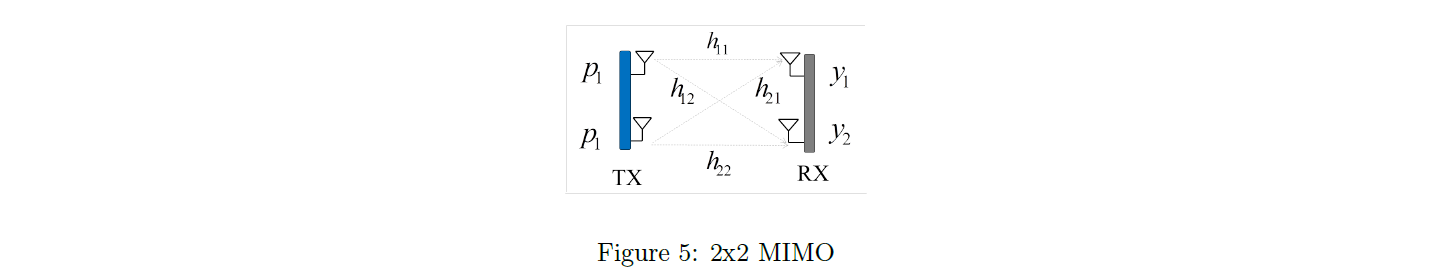

## 4.1. Without Alamouti code

For the first part of this lab, the transmitter transmits the same data packet on both its antennas. 
Only the preamble is different, and the data is the same. 
The packets use OFDM and their format is shown in Figure. 6.

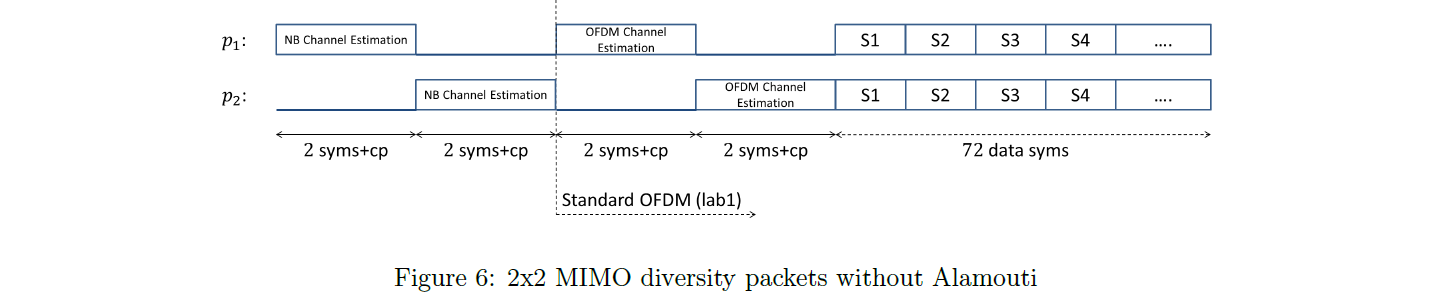


Implement the function ``decode_2x2_no_alamouti`` in the following cell. 
It should take two complex signals as input and should output one bit stream. 

Note that in this task you do not need to do Maximum Ratio Combining (MRC). 
Here you can just do addition of the signals, which was the first suboptimal option in the lecture.
Consequently, you just decode the packets similar to the ``decode_2x2_mimo`` function, and you decode the average of the two resulting packets.

To test your code and make sure that it works fine, you can use the file ``Eg_2x2_MIMO_NoAlamouti.mat``. 
This file contains two signals: ``rx_signal_1`` and ``rx_signal_2`` and one output bit stream: ``bits_data``. 
Your decoded bits should match the ``bits_data``. 

**Hints:** 

* Do not forget to skip 1/4 of the CP.


In [33]:
import numpy as np
from scipy.io import loadmat

"""
    @param rx_signal_1: The signal 1
    @type  rx_signal_1: numpy.ndarray: complex128
    @shape rx_signal_1: (N,)

    @param rx_signal_2: The signal 2
    @type  rx_signal_2: numpy.ndarray: complex128
    @shape rx_signal_2: (N,)
    
    @return bits_data: The decoded bit stream
    @type bits_data: numpy.ndarray: bool
    @shape bits_data: (M,)
"""
def decode_2x2_no_alamouti(rx_signal_1, rx_signal_2):
    # Load parameters from the MAT file
    params = loadmat('Mat_Files/Parameters.mat')
    cp = params['cp'].item()
    num_bins = params['num_bins'].item()

    # Your Code Starts Here #

    # Use this variable to keep track at which sample you are in the packet
    current_index = int(np.ceil(1 / 4 * cp))
    nb_len = 2 * num_bins + cp  # Length of narrowband preamble

    # Create narrowband H matrix
    # ... add your code here ...
    # Compute H as in decode_2x2_mimo
    nb1_rx1 = rx_signal_1[current_index:current_index + nb_len]
    nb1_rx2 = rx_signal_2[current_index:current_index + nb_len]
    nb2_rx1 = rx_signal_1[current_index + nb_len:current_index + 2 * nb_len]
    nb2_rx2 = rx_signal_2[current_index + nb_len:current_index + 2 * nb_len]

    h11 = estimate_narrowband_channel(nb1_rx1[:num_bins], nb1_rx1[num_bins:2*num_bins]) # TX1 -> RX1 on slot 1
    h21 = estimate_narrowband_channel(nb1_rx2[:num_bins], nb1_rx2[num_bins:2*num_bins]) # TX1 -> RX2 on slot 1
    h12 = estimate_narrowband_channel(nb2_rx1[:num_bins], nb2_rx1[num_bins:2*num_bins]) # TX2 -> RX1 on slot 2
    h22 = estimate_narrowband_channel(nb2_rx2[:num_bins], nb2_rx2[num_bins:2*num_bins]) # TX2 -> RX2 on slot 2

    H = np.array([[h11, h12],
                  [h21, h22]], dtype=np.complex128)
    current_index += 2 * nb_len

    # Join the two streams into one packet
    # ... add your code here ...
    rx_signal_1_ofdm = rx_signal_1[current_index:]
    rx_signal_2_ofdm = rx_signal_2[current_index:]
    Y = np.vstack((rx_signal_1_ofdm, rx_signal_2_ofdm))
    packet_samples = np.linalg.solve(H, Y)
    packet_samples_1 = packet_samples[0, :]
    packet_samples_2 = packet_samples[1, :]
    packet_samples_1 = np.concatenate([packet_samples_1[:nb_len], packet_samples_1[num_bins * 4 + cp * 2:]])
    packet_samples_2 = packet_samples_2[nb_len:]
    rx_signal = (packet_samples_1 + packet_samples_2) / 2

    # Decode the packet
    # ... add your code here ...
    bits_data = rx_ofdm_chain_synced(rx_signal)

    return bits_data

# Your Code Ends Here #

In [ ]:
# ## Code for debugging
# import scipy.io as sio
# import numpy as np

# # Load necessary .mat files
# debug_data = sio.loadmat('Mat_Files/Eg_2x2_MIMO_NoAlamouti.mat')
# params = sio.loadmat('Mat_Files/Parameters.mat')
# print(debug_data.keys())
# print(debug_data['rx_signal_1'].flatten().shape)
# print(debug_data['rx_signal_2'].flatten().shape)

# # Extract the rx_signals and initialize variables
# rx_signal_1 = debug_data['rx_signal_1'].flatten()
# rx_signal_2 = debug_data['rx_signal_2'].flatten()
# bits_data = decode_2x2_no_alamouti(rx_signal_1, rx_signal_2)
# print(bits_data.shape)

# debug_bits_data = debug_data['bits_data'].flatten()
# print(debug_bits_data.shape)

# print(f"Errors in decoding: {np.count_nonzero(bits_data != debug_bits_data)} / {bits_data.shape[0]}")
# print(bits_data)

dict_keys(['__header__', '__version__', '__globals__', 'bits_data', 'rx_signal_1', 'rx_signal_2'])
(6336,)
(6336,)
(3456,)
(3456,)
Errors in decoding: 0 / 3456
[False  True  True ...  True False False]


## 4.2. With Alamouti code

Now in the second part of this task, the transmitter transmits the data packet by coding across symbols using Alamouti code. 
The transmitter will transmit the packets in the format shown in Figure. 7.

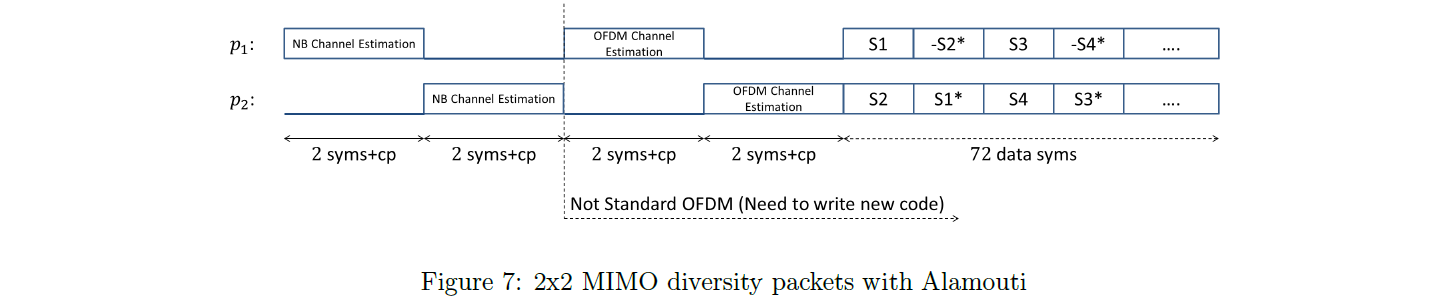

Recall, to decode Alamouti code, we have:

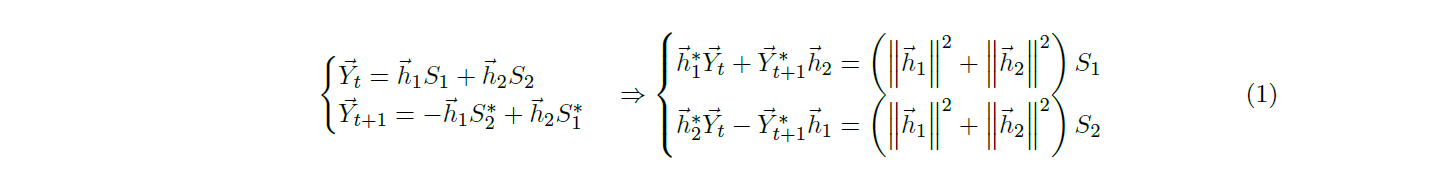

Implement the function ``decode_2x2_with_alamouti`` in the following cell. 
The difference is that now you can no longer mix the two packets into one and use the ``rx_ofdm_chain_synced`` function to decode it. 
You will have to write your own code to decouple the OFDM symbols. 
This function should take two complex signals as input and should output one bit stream.

**Hints:** 

* Note that you should not use the ``rx_ofdm_chain_synced`` directly anymore.
But you should use the other functions ``estimate_channel`` and ``correct_channel`` that we gave you in the Helper Functions section. 
* Do not forget to discard guard bins when decoding.
They carry no data to decode!
* Do not forget to comply with the output format specified for your function.
For example your output for ``bits_data`` should be ``ndarray:bool`` and not a list!
* Do not forget to skip 1/4 of the CP.

To test your code and make sure that it works fine, you can use the file ``Eg_2x2_MIMO_Alamouti.mat``. 
This file contains two signals: ``rx_signal_1`` and ``rx_signal_2`` and one output bit stream: ``bits_data``. 
Your decoded bits should match the ``bits_data``. 

In [ ]:
import numpy as np
from scipy.io import loadmat

"""
    @param rx_signal_1: The signal 1
    @type  rx_signal_1: numpy.ndarray: complex128
    @shape rx_signal_1: (N,)

    @param rx_signal_2: The signal 2
    @type  rx_signal_2: numpy.ndarray: complex128
    @shape rx_signal_2: (N,)
    
    @return bits_data: The decoded bit stream
    @type bits_data: numpy.ndarray: bool
    @shape bits_data: (M,)
"""
def decode_2x2_with_alamouti(rx_signal_1, rx_signal_2):
    # Load parameters from the MAT file
    params = loadmat('Mat_Files/Parameters.mat')
    cp = params['cp'].item()
    num_bins = params['num_bins'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()

    # Your Code Starts Here #

    # Use this variable to keep track at which sample you are in the packet
    current_index = int(np.ceil(1 * cp / 4))

    ## Estimate the narrowband channels
    # ... add your code here ...

    bits_data = []

    # Use this variable to help you set the data subcarriers from pilot subcarriers from unused subcarriers
    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3

    ## Estimate OFDM channel vector
    # ... add your code here ...

    ## Decode using Alamouti
    for m in range(0, num_syms_data, 2):
        # ... add your code here ...

    ## Convert the list to a numpy array
    bits_data = np.array(bits_data, dtype=bool)

    return bits_data

# Your Code Ends Here #

After implementing the functions, run the following cell (no modification is needed) to save your results in the ``Results`` folder for our evaluation. 
Make sure that your result ``Result_2x2_Diversity.mat`` is saved after running this cell.

In [ ]:
import numpy as np
from scipy.io import loadmat, savemat

def test_decode_2x2_diversity():
    # Load MATLAB files
    test_data = loadmat('Mat_Test/Test_2x2_Diversity.mat')

    rx_signals_no_alamouti = test_data['rx_signals_no_alamouti']
    rx_signals_with_alamouti = test_data['rx_signals_with_alamouti']
    
    num_test = rx_signals_no_alamouti.shape[1]
    bits_data_all_no_alamouti = []
    bits_data_all_with_alamouti = []

    for k in range(num_test):
        # No Alamouti
        rx_signal_1 = rx_signals_no_alamouti[0, k].flatten()
        rx_signal_2 = rx_signals_no_alamouti[1, k].flatten()
        bits_data_no_alamouti = decode_2x2_no_alamouti(rx_signal_1, rx_signal_2)
        bits_data_all_no_alamouti.append(bits_data_no_alamouti)
        
        # With Alamouti
        rx_signal_1 = rx_signals_with_alamouti[0, k].flatten()
        rx_signal_2 = rx_signals_with_alamouti[1, k].flatten()
        bits_data_with_alamouti = decode_2x2_with_alamouti(rx_signal_1, rx_signal_2)
        bits_data_all_with_alamouti.append(bits_data_with_alamouti)
    
    # Save results
    savemat('Results/Result_2x2_Diversity.mat', {
        'bits_data_no_alamouti': bits_data_all_no_alamouti,
        'bits_data_with_alamouti': bits_data_all_with_alamouti
    })

test_decode_2x2_diversity()

# 5. Submission Instructions

You should submit the following for evaluation as a single ``.zip`` on Moodle.

1. This file with all the required code being complete.
2. The ``Results`` folder which includes all the generated outputs through running the evaluation cells in this file.
3. A ``README.txt`` file stating your name and SCIPER as well as that of your partners.

<!-- Make sure to add your team members to your submission on Moodle and not only in the README file.  -->
Only one group member needs to submit. 
Make sure the .zip file does not include the ``Mat_Files`` and ``Mat_Test`` folder. 
We just need the code and ``Results`` folders.